Mode Connectivity **Implementation**

<>:198: SyntaxWarning: invalid escape sequence '\p'
<>:198: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2534077216.py:198: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t_values, path_losses, label='Bezier Path Loss ($\phi_{\\theta}(t)$)')


Starting Mode Connectivity Search (Epochs: 200, LR: 0.0005)
Parameter vector size: 652
Epoch 000/200: Avg Path Loss = 0.695930
Epoch 010/200: Avg Path Loss = 0.697231
Epoch 020/200: Avg Path Loss = 0.696015
Epoch 030/200: Avg Path Loss = 0.697689
Epoch 040/200: Avg Path Loss = 0.698205
Epoch 050/200: Avg Path Loss = 0.693073
Epoch 060/200: Avg Path Loss = 0.694987
Epoch 070/200: Avg Path Loss = 0.697277
Epoch 080/200: Avg Path Loss = 0.696414
Epoch 090/200: Avg Path Loss = 0.693726
Epoch 100/200: Avg Path Loss = 0.695612
Epoch 110/200: Avg Path Loss = 0.697004
Epoch 120/200: Avg Path Loss = 0.692790
Epoch 130/200: Avg Path Loss = 0.696279
Epoch 140/200: Avg Path Loss = 0.693694
Epoch 150/200: Avg Path Loss = 0.695868
Epoch 160/200: Avg Path Loss = 0.695746
Epoch 170/200: Avg Path Loss = 0.691981
Epoch 180/200: Avg Path Loss = 0.696792
Epoch 190/200: Avg Path Loss = 0.697145

Evaluating final path connectivity...
------------------------------
Max Loss on Path: 0.7069
Endpoint Loss (max

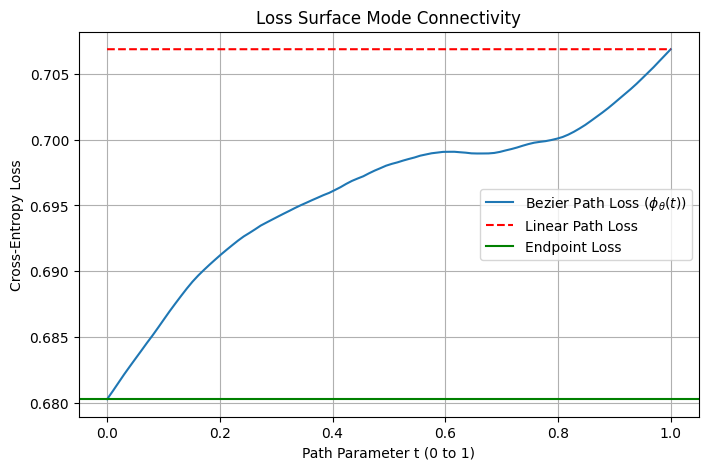

In [8]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict



def extract_parameters(model):
    """
    Extracts all parameters (weights and biases) into a single, flat tensor.
    """
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_parameters(model, flat_vector):
    """
    Sets the model's parameters using a flat vector, ensuring shapes are correct.
    """
    pointer = 0
    for p in model.parameters():
        num_params = torch.numel(p)

        p.data = flat_vector[pointer:pointer + num_params].view_as(p).data
        pointer += num_params

def evaluate_loss_for_grad(model, data_loader):
    """
    Calculates the loss for one batch, allowing gradient tracking for the curve optimization.
    NOTE: model.train() is used here to ensure Batch Norm layers (if present) are active
    and don't interfere with the loss graph, which is often done in literature.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()


    for inputs, targets in data_loader:



        outputs = model(inputs)
        loss = criterion(outputs, targets)
        return loss
    return torch.tensor(float('inf'), requires_grad=True)

def evaluate_loss_for_final_path(model, data_loader):
    """
    Calculates the loss for one batch for stable final evaluation. Uses no_grad.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for inputs, targets in data_loader:


        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        return loss.item()
    return float('inf')




def find_mode_connectivity(model_A, model_B, train_loader,curve_type='bezier', num_epochs=100, lr=1e-3):


    device = model_A.parameters().__next__().device


    w1 = extract_parameters(model_A).detach().to(device)
    w2 = extract_parameters(model_B).detach().to(device)


    if curve_type == 'bezier':
        theta_init = (w1 + w2) / 2
        theta = nn.Parameter(theta_init.data)
    else:
        raise NotImplementedError("Only 'bezier' is currently implemented.")


    optimizer = torch.optim.SGD([theta], lr=lr, momentum=0.9)

    print(f"Starting Mode Connectivity Search (Epochs: {num_epochs}, LR: {lr})")
    print(f"Parameter vector size: {len(w1)}")


    for epoch in range(num_epochs):

        optimizer.zero_grad()
        loss_samples = []


        for _ in range(10):

            t = torch.tensor(np.random.uniform(0, 1), device=device)


            w_t = (1 - t)**2 * w1 + 2 * t * (1 - t) * theta + t**2 * w2


            set_parameters(model_A, w_t)

            loss = evaluate_loss_for_grad(model_A, train_loader)
            loss_samples.append(loss)


        total_loss = torch.mean(torch.stack(loss_samples))


        total_loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}/{num_epochs}: Avg Path Loss = {total_loss.item():.6f}")


    print("\nEvaluating final path connectivity...")
    path_losses = []

    theta_final = theta.data

    for t in np.linspace(0, 1, 100):
        t_tensor = torch.tensor(t, device=device)

        w_t = (1 - t_tensor)**2 * w1 + 2 * t_tensor * (1 - t_tensor) * theta_final + t_tensor**2 * w2

        set_parameters(model_A, w_t)

        loss = evaluate_loss_for_final_path(model_A, train_loader)
        path_losses.append(loss)


    endpoint_loss = max(path_losses[0], path_losses[-1])
    barrier = max(path_losses) - endpoint_loss

    print("-" * 30)
    print(f"Max Loss on Path: {max(path_losses):.4f}")
    print(f"Endpoint Loss (max of A/B): {endpoint_loss:.4f}")
    print(f"Final Barrier Height: {barrier:.4f} (Ideally < 0.1)")

    return barrier, path_losses



if __name__ == '__main__':


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class SimpleNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(10, 50)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(50, 2)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x


    torch.manual_seed(42)
    model_A = SimpleNet().to(device)
    torch.manual_seed(100)
    model_B = SimpleNet().to(device)


    mock_inputs = torch.randn(64, 10).to(device)
    mock_targets = torch.randint(0, 2, (64,)).to(device)
    mock_loader = [(mock_inputs, mock_targets)]

    barrier, path_losses = find_mode_connectivity(
        model_A,
        model_B,
        mock_loader,
        curve_type='bezier',
        num_epochs=200,
        lr=5e-4
    )


    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        t_values = np.linspace(0, 1, 100)


        plt.plot(t_values, path_losses, label='Bezier Path Loss ($\phi_{\\theta}(t)$)')


        w1_data = extract_parameters(model_A).data.cpu()
        w2_data = extract_parameters(model_B).data.cpu()
        linear_losses = []
        for t in t_values:
            w_t_linear = (1 - t) * w1_data + t * w2_data
            set_parameters(model_A, w_t_linear.to(device))
            linear_losses.append(evaluate_loss_for_final_path(model_A, mock_loader))

        plt.plot(t_values, linear_losses, 'r--', label='Linear Path Loss')

        plt.axhline(y=path_losses[0], color='g', linestyle='-', label='Endpoint Loss')
        plt.title('Loss Surface Mode Connectivity')
        plt.xlabel('Path Parameter t (0 to 1)')
        plt.ylabel('Cross-Entropy Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    except ImportError:
        print("\nInstall matplotlib to visualize the path losses.")
        print(f"Path Losses: {path_losses[0]:.4f} -> ... -> {max(path_losses):.4f} -> ... -> {path_losses[-1]:.4f}")